**Intro to VAE:**<br>
A Variational Autoencoder (VAE) is a type of generative model and a variant of autoencoders used in machine learning and deep learning. VAEs are designed to learn a probabilistic representation of data, capturing the underlying structure of the input distribution. Unlike traditional autoencoders, VAEs introduce a probabilistic approach to the encoding and decoding processes, enabling them to generate new data samples by sampling from a learned probability distribution.

The key innovation of VAEs lies in their use of a latent space that follows a specific probability distribution, typically a multivariate normal distribution. During training, VAEs aim to learn both an encoder and a decoder. The encoder maps input data to the latent space, while the decoder reconstructs the input data from samples drawn from the latent space distribution. The introduction of probabilistic elements allows VAEs to generate diverse and meaningful outputs, making them particularly effective in capturing the inherent variability within a dataset.

VAEs find applications in various domains, including image generation, data compression, and representation learning. The probabilistic nature of the latent space makes them well-suited for tasks involving uncertainty and complex data distributions. Additionally, VAEs have been influential in the development of generative models and have contributed to advancements in unsupervised learning and variational inference techniques

As similar to an autoencoder, A VAE also has a encoder, decoder , and a latent space but in addition to these a VAE also has other components like difference in reparameterization and addition of regularization term in loss(KL divergence).<br>
The components of a VAE are:<br>
1. **Encoder:**
The encoder takes an input data point and maps it to a probability distribution in the latent space.
It consists of neural network layers that transform the input into the parameters of a multivariate normal distribution (mean and variance).

2. **Latent Space:**
The latent space is a lower-dimensional space where the encoder maps the input data.
In VAEs, this latent space follows a probability distribution, usually a multivariate normal distribution. The stochastic nature of the latent space allows for the generation of diverse and meaningful samples.

3. **Reparameterization:**
To make the training process differentiable, the reparameterization trick is used during the sampling from the latent space.
Instead of directly sampling from the distribution, the model samples from a fixed distribution (e.g., standard normal) and scales and shifts the samples based on the mean and variance predicted by the encoder.
4. **Decoder:**
The decoder takes a sample from the latent space and reconstructs the input data.
It is typically a neural network that learns to generate data similar to the input.
5. **Loss Function:**
VAEs use a combination of two loss functions during training: a reconstruction loss and a regularization term.
The reconstruction loss measures how well the reconstructed output matches the input.
The regularization term encourages the distribution in the latent space to be close to a standard normal distribution. This is often implemented using the Kullback-Leibler (KL) divergence.


To learn more about VAE's you refer to a medium blog [Understanding Variational autoencoders](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73).

Here, we are gonna build variational autoencoder model using convolutional ,pooling and transpose convloutional layers and apply it on cifar-10 dataset and training the model to get minimum reconstruction loss.

let start with loading the data.
Pytorch has already cifar-10 dataset so, we dont have to download it explicilty.

Now we have to get the data from torchvision.datasets with applied transforms
Then we have to load the data into batches, training data in batches takes computation cost.

In [1]:
import torch

In [2]:
from torchvision import datasets
import torchvision

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    torchvision.transforms.RandomHorizontalFlip(),
])
train_data = datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=16,
                                              shuffle=True, num_workers=2)
test_data = datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
testloader = torch.utils.data.DataLoader(test_data, batch_size=16,
                                             shuffle=False, num_workers=0)


100%|██████████| 170498071/170498071 [00:13<00:00, 12614763.34it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Lets display some images, from the loaded data.<br>
visualization helps us to understand the data and we know on what we are doing our training rather just thinking them as bunch of numbers.
Here im using matplotlib.pyplot , matplotlib is popular python library to visualize data.

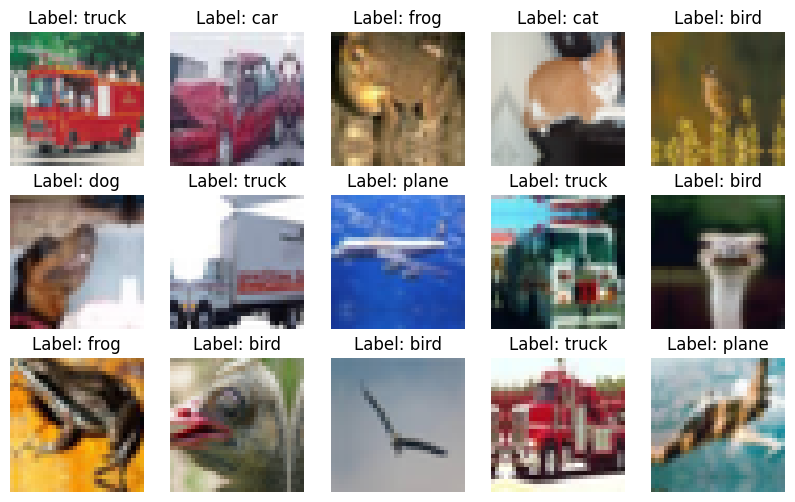

In [3]:
import matplotlib.pyplot as plt
import random
import numpy as np

random.seed(56)
num_cols=5
num_rows=3
Labels = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 6))
for i in range(num_cols*num_rows):
  img,label=train_data[random.randint(0,50000)]
  row = i // num_cols
  col = i % num_cols
  axes[row, col].imshow(np.transpose(img, (1, 2, 0)))
  axes[row, col].set_title(f"Label: {Labels[label]}")
  axes[row, col].axis('off')

checking the device, if gpu available change the device to gpu. Training on gpu makes training process makes faster than training it on a cpu.

In [4]:
if (torch.cuda.is_available()):
  device='cuda'
else:
  device='cpu'
device

'cuda'

Now coming to model architecture, for a VAE the majority portion is similar to an autoencoder and additionally a VAE has probabilistic elements(mean & variance). we are using convolutional layers rather than linear layers cause we are dealing with image data and convolution layers retains connection with sourrounding elements.

In [5]:
import torch.nn as nn


class VAE(nn.Module):
  def __init__(self,latent_dim=192):
    super(VAE, self).__init__()
    #encoder
    self.encoder = nn.Sequential(
        nn.Conv2d(3,3,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(32*32*3,16*16*3),
        nn.ReLU(),
        nn.Linear(16*16*3,latent_dim),
        nn.ReLU(),
        nn.Dropout(0.2),
        )
    #probabilistic parameters(mean, variance)
    self.mean_layer=nn.Linear(latent_dim,2)
    self.var_layer=nn.Linear(latent_dim,2)
    #decoder
    self.decoder = nn.Sequential(
        nn.Linear(2,latent_dim),
        nn.ReLU(),
        nn.Linear(latent_dim,16*16*3),
        nn.ReLU(),
        nn.Linear(16*16*3,32*32*3),
        nn.Unflatten(1, (3, 32, 32)),
        nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1),
        nn.Sigmoid()
        )
  def encode(self,x):
    x=self.encoder(x)
    mean=self.mean_layer(x)
    var=self.var_layer(x)
    return mean,var

  def decode(self,x):
    return self.decoder(x)

  def reparameterization(self, mean, var):
    device ='cuda' if torch.cuda.is_available() else 'cpu'
    epsilon = torch.randn_like(var).to(device)
    z = mean + var*epsilon
    return z

  def forward(self, x):
    mean, var = self.encode(x)
    z = self.reparameterization(mean, var)
    output = self.decode(z)
    return output, mean, var

In [6]:
model =VAE().to(device)
model

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=3072, out_features=768, bias=True)
    (4): ReLU()
    (5): Linear(in_features=768, out_features=192, bias=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
  )
  (mean_layer): Linear(in_features=192, out_features=2, bias=True)
  (var_layer): Linear(in_features=192, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=192, bias=True)
    (1): ReLU()
    (2): Linear(in_features=192, out_features=768, bias=True)
    (3): ReLU()
    (4): Linear(in_features=768, out_features=3072, bias=True)
    (5): Unflatten(dim=1, unflattened_size=(3, 32, 32))
    (6): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Sigmoid()
  )
)

After defining model structure, now we have to train the model.<br>
for that we have first declare loss function and optimiszer. Here, I'm using Adam optimiser.
For loss function, in a VAE loss function contains, a re-construction loss and Kullback–Leibler(KL) divergence. The KL divergence is a metric used to measure the distance between two probability distributions.

In [7]:
def loss_func(x,output,mean,var):
  #reconstruction loss
  loss=nn.functional.binary_cross_entropy(output, x)
  #kl divergence
  kl_div= ((mean**2 + var.exp() - 1 - var) / 2).mean()
  return loss+kl_div

In [8]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

Finally, we train our model, using above optimiser and loss fuunction.

In [9]:
from torch.autograd import Variable
def get_torch_vars(x):
  if torch.cuda.is_available():
        x = x.cuda()
  return Variable(x)

model.train()
for epoch in range(20):
  running_loss = []
  for i, (inputs, _) in enumerate(trainloader, 0):
    inputs = get_torch_vars(inputs)
    outputs,mean,var = model(inputs)
    loss = loss_func(inputs,outputs,mean,var)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss.append(loss.data)
    if i % 2000 == 1999:
      print('[epoch: %d] loss: %.5f' %(epoch + 1,sum(running_loss)/len(running_loss)))

[epoch: 1] loss: 0.66616
[epoch: 2] loss: 0.64185
[epoch: 3] loss: 0.63766
[epoch: 4] loss: 0.63743
[epoch: 5] loss: 0.63672
[epoch: 6] loss: 0.63675
[epoch: 7] loss: 0.63653
[epoch: 8] loss: 0.63675
[epoch: 9] loss: 0.63659
[epoch: 10] loss: 0.63673
[epoch: 11] loss: 0.63655
[epoch: 12] loss: 0.63625
[epoch: 13] loss: 0.63685
[epoch: 14] loss: 0.63629
[epoch: 15] loss: 0.63659
[epoch: 16] loss: 0.63675
[epoch: 17] loss: 0.63704
[epoch: 18] loss: 0.63634
[epoch: 19] loss: 0.63670
[epoch: 20] loss: 0.63677


Trained model on test data we got similar loss from training process.

In [10]:
model.eval()
test_loss=[]
for i,(inputs,label) in enumerate(testloader,0):
  inputs = get_torch_vars(inputs)
  test_outputs,mean,var = model(inputs)
  loss = loss_func(inputs, test_outputs,mean,var)
  test_loss.append(loss.data)
print('loss: %.5f' %(sum(test_loss)/len(test_loss)))

loss: 0.63663


In comperission to an autoencoder, A VAE is diiferent in follwoing ways:<br>

1.   Probabilistic Nature of Latent Space
2.   Regularization Through KL Divergence
3.   Generative Capability

